# Find The Gap, get data

David Silva, UTSA  
Last major revision 2025-01-08

Based on: 
https://github.com/contardog/FindTheGap/blob/main/examples/example_MW_2D.ipynb

Starting from the original Contardo et al. FindTheGap example, the current notebook downloads the relevant Gaia DR3 data, applies their filters, converts to galactocentric coordinates, applies their filters, and then reproduces their Figure 1.

Gaia source catalog data dictionary  
https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_main_source_catalogue/ssec_dm_gaia_source.html



## Preamble

In [1]:
# standard Python libraries
import numpy as np
import pandas as pd
import os.path
import sys

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# # vo, astropy
# from astropy.table import Table
# from astropy import units as u
# from astropy.coordinates import SkyCoord

# from pyvo.dal import sia

%matplotlib inline

In [2]:
# if not present, install galpy, a library for manipulating Gaia data
# https://docs.galpy.org/en/v1.10.1/

import sys
import subprocess

# def install_and_import(package):
#     try:
#         __import__(package)
#         print(f"{package} is already installed.")
#     except ImportError:
#         print(f"Installing {package}...")
#         subprocess.check_call([sys.executable, "-m", "pip", "install", package])
#         print(f"{package} has been installed.")

# install_and_import('galpy')

# import coords 
from galpy.util import coords

In [3]:
# setup ESA Gaia cloud access
# get tables to validate connection
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Select Data Release 3
tables = Gaia.load_tables()

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


## Get Gaia data

Repeating Contardo et al. 2022 data pull. They used Gaia eDR3, here we use Gaia DR3. The original cuts are defined in Section 2 ("Example Data") as follows:

Quality cuts:

* bp_rp < 1.5
* phot_g_mean_mag < 14.5
* parallax/parallax_error > 4.
* parallax_error < 0.1
* visibility_periods_used > 5.
* phot_bp_rp_excess_factor < 1.3
* phot_bp_rp_excess_factor > 1.172


Distance cuts (all within 200pc)

* 1./parallax < 0.2
* abs(z) < .2
* abs(phi) < np.arcatan(.2 / 8.178)
* abs(r - r0) < .2

Cuts on velocities:

* abs(vR) < 125
* 100 < vPhi < 300

In [4]:
# get Gaia DR3 data using "quality cuts" specified above
# including distance cut 1. / parallax < 0.2 to limit number of objects selected
# I infer that Cortado et al. retrieved all columns; here, I just get the columns I need or want

query = '''
SELECT TOP 500000
    s.ra, 
    s.dec,
    s.l,
    s.b,
    s.pmra,
    s.pmdec,
    s.bp_rp,
    s.radial_velocity,
    s.phot_g_mean_mag,
    s.parallax,
    s.parallax_error,
    s.visibility_periods_used,
    s.phot_bp_rp_excess_factor,
    s.phot_bp_rp_excess_factor
FROM
    gaiadr3.gaia_source AS s
WHERE
    s.bp_rp < 1.5 
    AND s.phot_g_mean_mag < 14.5
    AND s.parallax/s.parallax_error > 4.
    AND s.parallax_error < 0.1 
    AND s.visibility_periods_used > 5.
    AND s.phot_bp_rp_excess_factor < 1.3 
    AND s.phot_bp_rp_excess_factor > 1.172
    AND 1./s.parallax < 0.2
'''

print(query)


SELECT TOP 500000
    s.ra, 
    s.dec,
    s.l,
    s.b,
    s.pmra,
    s.pmdec,
    s.bp_rp,
    s.radial_velocity,
    s.phot_g_mean_mag,
    s.parallax,
    s.parallax_error,
    s.visibility_periods_used,
    s.phot_bp_rp_excess_factor,
    s.phot_bp_rp_excess_factor
FROM
    gaiadr3.gaia_source AS s
WHERE
    s.bp_rp < 1.5 
    AND s.phot_g_mean_mag < 14.5
    AND s.parallax/s.parallax_error > 4.
    AND s.parallax_error < 0.1 
    AND s.visibility_periods_used > 5.
    AND s.phot_bp_rp_excess_factor < 1.3 
    AND s.phot_bp_rp_excess_factor > 1.172
    AND 1./s.parallax < 0.2



In [5]:
# run query
# this returns a VO Table
# query execution takes a few seconds
# result retrival takes minutes (depends on bandwidth)

# Submit the job asynchronously and anonymously
print("Submitting job...")
job = Gaia.launch_job_async(query, verbose=True)
print(f"Job ID: {job.jobid}")

# # Check job status and wait for completion
# while True:
#     status = job.get_phase()
#     print(f"Job status: {status}")
#     if status == 'COMPLETED':
#         break
#     elif status in ['ERROR', 'ABORTED']:
#         raise Exception(f"Job failed with status: {status}")
#     time.sleep(5)  # Wait 5 seconds before checking again

# Retrieve and process results
print("\n\nRetrieving results...", end='')
gaia = job.get_results()

print("...DONE")

Submitting job...
Launched query: '
SELECT TOP 500000
    s.ra, 
    s.dec,
    s.l,
    s.b,
    s.pmra,
    s.pmdec,
    s.bp_rp,
    s.radial_velocity,
    s.phot_g_mean_mag,
    s.parallax,
    s.parallax_error,
    s.visibility_periods_used,
    s.phot_bp_rp_excess_factor,
    s.phot_bp_rp_excess_factor
FROM
    gaiadr3.gaia_source AS s
WHERE
    s.bp_rp < 1.5 
    AND s.phot_g_mean_mag < 14.5
    AND s.parallax/s.parallax_error > 4.
    AND s.parallax_error < 0.1 
    AND s.visibility_periods_used > 5.
    AND s.phot_bp_rp_excess_factor < 1.3 
    AND s.phot_bp_rp_excess_factor > 1.172
    AND 1./s.parallax < 0.2
'
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = application/x-www-form-urlencoded
303 303
[('Date', 'Mon, 10 Feb 2025 22:28:21 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protect

In [6]:
# Display information about the retrieved data

print("\nGaia Results Info:")
print(f"Number of rows: {len(gaia)}")
print(gaia.columns)



Gaia Results Info:
Number of rows: 301274
<TableColumns names=('ra','dec','l','b','pmra','pmdec','bp_rp','radial_velocity','phot_g_mean_mag','parallax','parallax_error','visibility_periods_used','phot_bp_rp_excess_factor','phot_bp_rp_excess_factor2')>


In [7]:
# Save results to disk

gaia.write('find_the_gap_data.fits')

## Convert to galactocentric coordinates

Original code: Cortado et al. example notebook  
Revisions by Silva
* Code formatting to be more Pythonic and readable
* Additional comments to explain steps


In [8]:
# convert to galactocentric coordinates - Cortado et al. example notebook

# Parameters to convert from observational to Galactocentric coordinates

# Distance from Sun to Galactic centre
ro = 8.178
# Circular velocity at Solar radius
vo = 248.5-12.32
# Sun's height above the disc plane
zo = 0.0208
# Sun's motion towards (away from) Galactic centre
u0 = -12.9
# Sun's peculiar motion in direction of rotation
v0 = 12.32
# Sun's vertical motion away from plane
w0 = 8.5

# Convert observed Galactic longitude and latitude (l, b) to Galactocentric Cartesian XYZ
XYZ = coords.lbd_to_XYZ(gaia['l'], gaia['b'], 1.0/gaia['parallax'], degree=True)

# Convert observed PMRA, PMDEC motions to Galactic longitude and latitude frame
pmllbb = coords.pmrapmdec_to_pmllpmbb(gaia['pmra'], gaia['pmdec'], 
                                      gaia['ra'], gaia['dec'], 
                                      degree=True, epoch=None
                                     )

# Convert PM_l, PM_b to motions in Galactocentric Cartesian XYZ
vxyz = coords.vrpmllpmbb_to_vxvyvz(gaia['radial_velocity'], 
                                   pmllbb[:,0],pmllbb[:,1],
                                   XYZ[:,0], XYZ[:,1], XYZ[:,2],
                                   XYZ=True, degree=True)

# Convert Galactocentric Cartesian XYZ coordinates to Galactocentric cylindrical
rpz = coords.XYZ_to_galcencyl(XYZ[:,0], XYZ[:,1], XYZ[:,2], ro, zo)

# Convert Galactocentric Cartesian XYZ velocities to Galactocentric cylindrical velocities
vcyl = coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], 
                                  XYZ[:,0]+ro, XYZ[:,1], XYZ[:,2]+zo,
                                  [u0, vo+v0, w0],
                                  ro, zo)

## Define quality, distance, and velocity masks

In essence, masks are boolean arrays where True (1) denotes "use data value" and False (0) denots "ignore data value". Here, separate masks are created and then multipled to create a single, global mask. It is implicitly assumed that the original data array (gaia) and all derived arrays (e.g., Galactocentric coordinates and velocities) have the same length (number of rows); hence, the global mask works for all data arrays. 



In [9]:
# CONTARDO: qindx is quality index, roughly what is 'good data'
# SILVA: define data quality mask (already done during SELECT, no harm repeating)

qindx = \
    (gaia['bp_rp'] < 1.5)  * \
    (gaia['phot_g_mean_mag'] < 14.5) * \
    (gaia['parallax']/gaia['parallax_error'] > 4.) * \
    (gaia['parallax_error'] < 0.1) * \
    (gaia['visibility_periods_used'] > 5.) * \
    (gaia['phot_bp_rp_excess_factor'] < 1.3) * \
    (gaia['phot_bp_rp_excess_factor'] > 1.172)

# CONTARDO: sindx is Jason's selection index. So, this one is everything < 200 pc from the Sun
# SILVA: Who is Jason?
# SILVA: define distance-from-Earth mask (already done during SELECT, no harm repeating)

sindx = (1. / gaia['parallax'] < 0.2)

# CONTARDO: no comment
# SILVA: define distance mask relative to Galactocentric position

z_200pc = np.fabs(rpz[:,2]) < 0.2
phi_200 = np.fabs(rpz[:,1]) < np.arctan(0.2/8.178)
r_200 = (np.fabs(rpz[:,0]-ro )< 0.2)

# CONTARDO: no comment
# SILVA: define velocity mask relative to Galactocentric position

vrmask = np.fabs(vcyl[:,0]) < 125
vphimask = (vcyl[:,1] < 300) & (vcyl[:,1] > 100)

# CONTARDO: no comment
# SILVA: combine all masks above into single, combined mask

all_mask = qindx * sindx * z_200pc * phi_200 *r_200 * vrmask * vphimask

# SILVA: added step to report results of filtering

gaia_filtered = gaia[all_mask]

# Print results
print(f"Original number of sources: {len(gaia)}")
print(f"Number of sources after filtering: {len(gaia_filtered)}")
print(f"Fraction of sources kept: {len(gaia_filtered)/len(gaia)*100:.1f}%")
print()


Original number of sources: 301274
Number of sources after filtering: 286866
Fraction of sources kept: 95.2%



## Create 2D array data_nonorm

In the Contardo et al. example, array "data_nonorm" is read from a disk file "data_MW_cut.npy". 

Here, we create "data_nonorm" from the above Galactocentric velocities in cylindrical coordinates. In princple, this step could be skipped, i.e., we could use the vr and vphi directly. However, data_nonorm is created so we can just cut-and-paste code from the Contardo et al. example.


In [10]:
data_nonorm = np.column_stack((vcyl[all_mask][:,0], vcyl[all_mask][:,1])) # vr, vphi

## Create Contardo et al. Figure 1

This code is cut-and-paste from the example notebook.

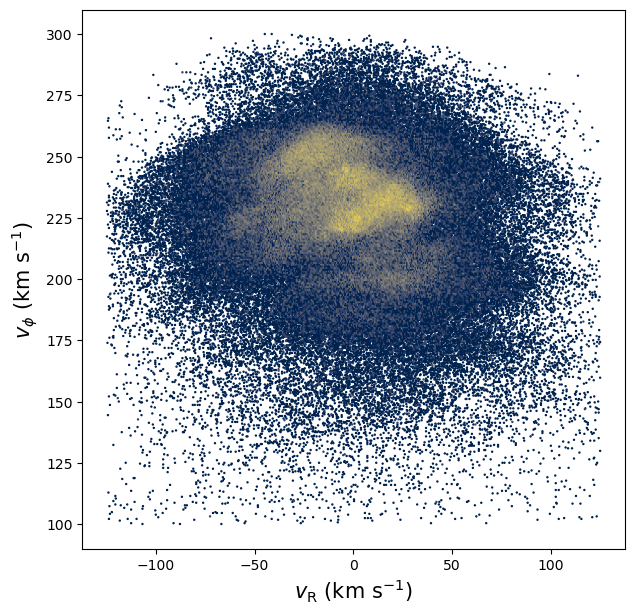

In [11]:
plt.figure(figsize=(7,7))
plt.hexbin(data_nonorm[:,0],data_nonorm[:,1],
           gridsize=500, bins='log', mincnt=1, cmap=cm.cividis) 

plt.xlabel(r'$v_{\mathrm{R}}\ (\mathrm{km\ s}^{-1})$',fontsize=15)
plt.ylabel(r'$v_{\phi}\ (\mathrm{km\ s}^{-1})$',fontsize=15)
plt.show()


In [13]:
gaia_filtered.info

<Table length=286866>
           name            dtype    unit                          description                       
------------------------- ------- -------- ---------------------------------------------------------
                       ra float64      deg                                           Right ascension
                      dec float64      deg                                               Declination
                        l float64      deg                                        Galactic longitude
                        b float64      deg                                         Galactic latitude
                     pmra float64 mas / yr                Proper motion in right ascension direction
                    pmdec float64 mas / yr                    Proper motion in declination direction
                    bp_rp float32      mag                                            BP - RP colour
          radial_velocity float32   km / s                           